# **Используемые библиотеки**

In [101]:
!pip install nltk scikit-learn
!pip install pymorphy2
import requests
import json
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
from pymorphy2 import MorphAnalyzer
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pymorphy2
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold,StratifiedKFold,LeaveOneOut, cross_val_score
import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Сбор данных и их анализ**

In [3]:
def clean_text(text):
    # Функция для очистки текста от лишних символов
    return text.replace("&lt;p&gt;", "").replace("\n", "").replace("br", "").replace("lt", "").replace("gt;", "").replace("\t", "").replace("\xa0&lt;/p&gt;", "").replace("\\"," ")

def fetch_data(url):
    # Функция для загрузки данных с веб-страницы и извлечения JSON
    response = requests.get(url)
    bs = BeautifulSoup(response.text, "lxml")
    temp = bs.find('script', {'type': 'application/ld+json'})
    text = clean_text(temp.text)
    text = ''.join(char for char in text if char.isprintable())
    return json.loads(text, strict=False)['review']

def parse(bank_name):
    data = []
    for page_number in range(2, 21):
        url = f'https://www.banki.ru/services/responses/bank/{bank_name}/?page={page_number}&is_countable=on'
        data.extend(fetch_data(url))

    for entry in data:
        entry['reviewRating'] = entry['reviewRating']['ratingValue']
        entry['bank'] = bank_name

    return data

def main():
    banks = ['alfabank', 'tcs', 'vtb', 'pochtabank', 'sberbank']
    all_data = []

    for bank in banks:
        all_data.extend(parse(bank))

    df = pd.DataFrame(all_data)
    df = df.drop(['@type', 'datePublished', 'author'], axis=1)
    df['description'] = df['description'].str.replace('\W', ' ')
    df.to_csv('/bankReviews.csv', index=False)

if __name__ == "__main__":
    main()

<ipython-input-3-d32bbbf687cc>:35: FutureWarning: The default value of regex will change from True to False in a future version.
  df['description'] = df['description'].str.replace('\W', ' ')


In [94]:
# Чтение данных из CSV файла
df = pd.read_csv('/bankReviews.csv')
df

,description,name,reviewRating,bank
0,Здравствуйте p 12 сентября 2023 года в прил...,Помогли разобраться с задолженностью на кредит...,5.0,alfabank
1,Открыла счет ИП т к были выгодняе условия по...,Оператор с вами свяжется никогда,1.0,alfabank
2,Несколько лет назад была зарплатным клиентом А...,Приятные впечатления от посещения офиса банка,5.0,alfabank
3,Банк предлагает иногда дни суперкэшбека в опре...,Консультация в чате,5.0,alfabank
4,24 августа появилась непонятная операция с при...,Помощь с непонятной операцией,5.0,alfabank
...,...,...,...,...
2370,Пишу второй отзыв Первый был по выделению дол...,"Банк, с которым вам ни связаться, ни сроков по...",1.0,sberbank
2371,Я продаю свою квартиру которая находится в ип...,Банк потерял мою закладную,1.0,sberbank
2372,02 08 2023 через банкомат и проведение Самоинк...,Самоинкассация,3.0,sberbank
2373,Долгое время пользуюсь услугами Сбербанка в т...,Изящно изменили условия рекламного предложения,2.0,sberbank


**description:** содержит описание отзывов, в которых клиенты выражают свое мнение о банке и его услугах. Описание может включать в себя как положительные, так и отрицательные аспекты опыта клиента с банком.

**name:** В этом столбце указаны названия или заголовки, которые клиенты дали своим отзывам. Эти заголовки могут предоставить дополнительную информацию о содержании отзыва.

**reviewRating:** Этот столбец содержит оценки банков. Они представлены числом с плавающей точкой и могут быть как положительные, так и отрицательные.

**bank:** В этом столбце указано название банка, к которому относится каждый отзыв. Он помогает идентифицировать, о каком банке идет речь в каждом конкретном отзыве.

In [45]:
# Cтатистика отзывов по каждому банку
df.groupby('bank').describe()['reviewRating']

,count,mean,std,min,25%,50%,75%,max
bank,,,,,,,,
alfabank,475.0,4.513684,1.236455,1.0,5.0,5.0,5.0,5.0
pochtabank,474.0,1.786920,1.425737,1.0,1.0,1.0,2.0,5.0
sberbank,472.0,1.745763,1.331866,1.0,1.0,1.0,2.0,5.0
tcs,475.0,4.776842,0.879136,1.0,5.0,5.0,5.0,5.0
vtb,475.0,2.677895,1.847405,1.0,1.0,2.0,5.0,5.0


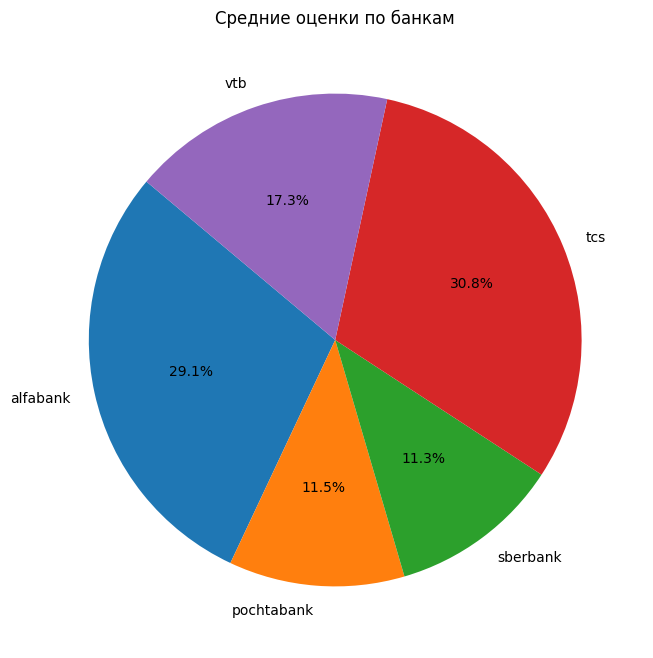

In [46]:
# Группируем данные по банкам и вычисляем средние оценки
mean_ratings = df.groupby('bank')['reviewRating'].mean().reset_index()

# Извлекаем банки и средние оценки
banks = mean_ratings['bank']
ratings = mean_ratings['reviewRating']

plt.figure(figsize=(8, 8))
plt.pie(ratings, labels=banks, autopct='%1.1f%%', startangle=140)

plt.title('Средние оценки по банкам')

plt.show()

<ipython-input-47-fe22259ee3d6>:3: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.histplot(data=df, x="reviewRating", hue="bank", multiple="stack", discrete=True, palette=custom_palette)


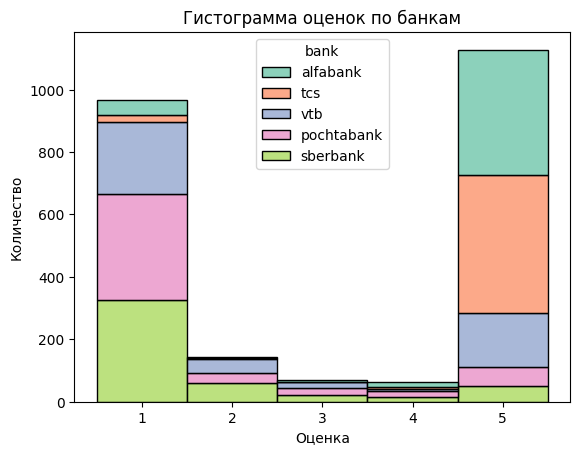

In [47]:
custom_palette = sns.color_palette("Set2")

sns.histplot(data=df, x="reviewRating", hue="bank", multiple="stack", discrete=True, palette=custom_palette)

plt.xlabel("Оценка")
plt.ylabel("Количество")
plt.title("Гистограмма оценок по банкам")

plt.show()

**Выводы:** На графиках мы видим, что лидирующим банком является Тинькоф, который собрал больше всего положительных отзывов и меньше всего отрицательных. За ним следует Альфабанк. ВТБ, Почтабанк и Сбербанк проявили себя хуже всего.

Выделим тот факт, что классы с оценками "2", "3" и "4" представлены плохо, поэтому можно будет объединить оценки "1", "2", "3" как "плохо" и "4", "5" как "хорошо".

# **Предпроцессинг данных**

In [58]:
# Приведем все к нижнему регистру
df['description'] = df['description'].str.lower()
df['name'] = df['name'].str.lower()
df.head()

,description,name,reviewRating,bank
0,здравствуйте p 12 сентября 2023 года в прил...,помогли разобраться с задолженностью на кредит...,5.0,alfabank
1,открыла счет ип т к были выгодняе условия по...,оператор с вами свяжется никогда,1.0,alfabank
2,несколько лет назад была зарплатным клиентом а...,приятные впечатления от посещения офиса банка,5.0,alfabank
3,банк предлагает иногда дни суперкэшбека в опре...,консультация в чате,5.0,alfabank
4,24 августа появилась непонятная операция с при...,помощь с непонятной операцией,5.0,alfabank


In [59]:
# Инициализируем объект для лемматизации
morph = pymorphy2.MorphAnalyzer()

# Загрузите список стоп-слов для русского языка
stopWords = set(stopwords.words('russian'))

# Функция для предобработки текста
def preprocess_text(text):
    tokens = text.split()
    tokens = [morph.parse(token)[0].normalized.word for token in tokens if token not in stopWords and not re.search('[^а-яА-Я0-9]', token)]
    return ' '.join(tokens)

# Применяем предобработку к столбцам 'description' и 'name'
df['description'] = df['description'].apply(preprocess_text)
df['name'] = df['name'].apply(preprocess_text)
df.head()

,description,name,reviewRating,bank
0,здравствуйте 12 сентябрь 2023 год приложение а...,помочь разобраться задолженность кредитный карта,5.0,alfabank
1,открыть счёт ип так выгодняй условие торговый ...,оператор вы связаться,1.0,alfabank
2,несколько год назад зарплатный клиент альфа ба...,приятный впечатление посещение офис банк,5.0,alfabank
3,банк предлагать день суперкэшбек категория июл...,консультация чат,5.0,alfabank
4,24 август появиться непонятный операция приход...,помощь непонятный операция,5.0,alfabank


In [60]:
# Преобразование оценок в категории "хорошо" (2) и "плохо" (1)
df['reviewRating'] = df['reviewRating'].apply(lambda x: 2 if x >= 4 else 1)
df.head()

,description,name,reviewRating,bank
0,здравствуйте 12 сентябрь 2023 год приложение а...,помочь разобраться задолженность кредитный карта,2,alfabank
1,открыть счёт ип так выгодняй условие торговый ...,оператор вы связаться,1,alfabank
2,несколько год назад зарплатный клиент альфа ба...,приятный впечатление посещение офис банк,2,alfabank
3,банк предлагать день суперкэшбек категория июл...,консультация чат,2,alfabank
4,24 август появиться непонятный операция приход...,помощь непонятный операция,2,alfabank


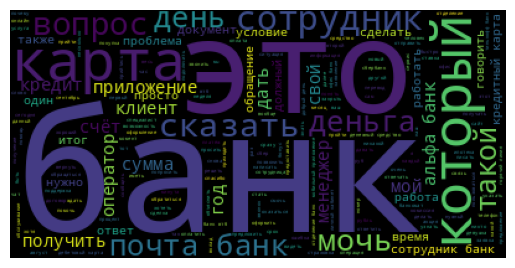

In [61]:
# Создаем облако слов
wordcloud = WordCloud().generate(' '.join(df['description']))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [62]:
y = df['reviewRating']
X = df.drop('reviewRating', axis = 1)
X

,description,name,bank
0,здравствуйте 12 сентябрь 2023 год приложение а...,помочь разобраться задолженность кредитный карта,alfabank
1,открыть счёт ип так выгодняй условие торговый ...,оператор вы связаться,alfabank
2,несколько год назад зарплатный клиент альфа ба...,приятный впечатление посещение офис банк,alfabank
3,банк предлагать день суперкэшбек категория июл...,консультация чат,alfabank
4,24 август появиться непонятный операция приход...,помощь непонятный операция,alfabank
...,...,...,...
2370,писать второй отзыв первый выделение доля срок...,который срок услуга слишком ваш мирской дело,sberbank
2371,продавать квартира который находиться ипотека ...,банк потерять мой закладная,sberbank
2372,02 08 2023 банкомат проведение самоинкассация ...,самоинкассация,sberbank
2373,долгий время пользоваться услуга сбербанк числ...,изящно изменить условие рекламный предложение,sberbank


In [63]:
# Инициализируем TF-IDF векторизатор
tfidf = TfidfVectorizer()

# Преобразуем текстовые данные в векторы TF-IDF
X = tfidf.fit_transform(X['description'].tolist())

In [64]:
print(X)

  (0, 8401)	0.046050124374992445
  (0, 12069)	0.09277202727362337
  (0, 7176)	0.056354362434451445
  (0, 7074)	0.057800491533653846
  (0, 2867)	0.04758500309672642
  (0, 7934)	0.08449951657400896
  (0, 10107)	0.0811658675914326
  (0, 8144)	0.055177496648321625
  (0, 10484)	0.04380175248032205
  (0, 6332)	0.0513533073414224
  (0, 2983)	0.03286027674184068
  (0, 10153)	0.05718930984557924
  (0, 2950)	0.07091078404285736
  (0, 7020)	0.042890691537590446
  (0, 3453)	0.05227543834583087
  (0, 3191)	0.06782545550720591
  (0, 3941)	0.051413175774103606
  (0, 8743)	0.05968568647371801
  (0, 8878)	0.06300220759367556
  (0, 6963)	0.0749806685596013
  (0, 7483)	0.11305976261578421
  (0, 2241)	0.12428486018492355
  (0, 5475)	0.033207312720181424
  (0, 10257)	0.06181960988783258
  (0, 7602)	0.06717759341251762
  :	:
  (2374, 10385)	0.1080535148537548
  (2374, 9663)	0.15381332079909876
  (2374, 9369)	0.12822101430023602
  (2374, 5492)	0.10130198145502725
  (2374, 9114)	0.11672198243280055
  (2374, 3

# **Избавление от разбалансировки классов**

In [65]:
# Cтатистика отзывов по каждому банку
df.groupby('bank').describe()['reviewRating']

,count,mean,std,min,25%,50%,75%,max
bank,,,,,,,,
alfabank,475.0,1.877895,0.327753,1.0,2.0,2.0,2.0,2.0
pochtabank,475.0,1.166316,0.372756,1.0,1.0,1.0,1.0,2.0
sberbank,475.0,1.138947,0.346256,1.0,1.0,1.0,1.0,2.0
tcs,475.0,1.945263,0.227706,1.0,2.0,2.0,2.0,2.0
vtb,475.0,1.378947,0.485636,1.0,1.0,1.0,2.0,2.0


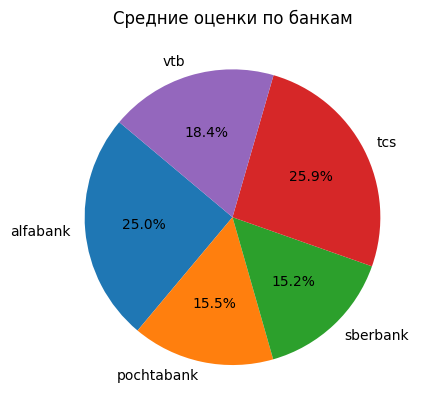

In [66]:
# Группируем данные по банкам и вычисляем средние оценки
mean_ratings = df.groupby('bank')['reviewRating'].mean().reset_index()

# Извлекаем банки и средние оценки
banks = mean_ratings['bank']
ratings = mean_ratings['reviewRating']


plt.pie(ratings, labels=banks, autopct='%1.1f%%', startangle=140)

plt.title('Средние оценки по банкам')

plt.show()

<ipython-input-67-3e399e4c9f77>:3: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.histplot(data=df, x="reviewRating", hue="bank", multiple="stack", discrete=True, palette=custom_palette)


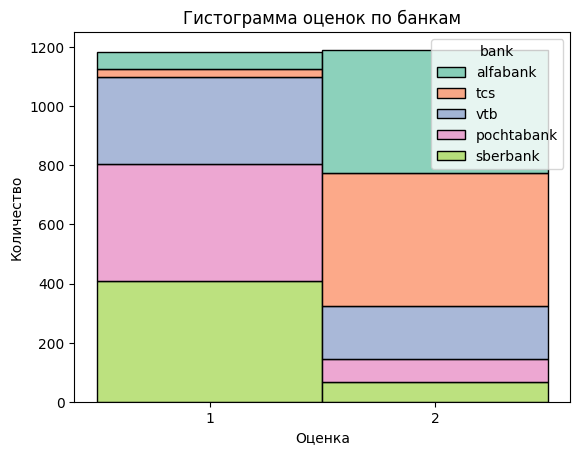

In [67]:
custom_palette = sns.color_palette("Set2")

sns.histplot(data=df, x="reviewRating", hue="bank", multiple="stack", discrete=True, palette=custom_palette)

plt.xlabel("Оценка")
plt.ylabel("Количество")
plt.title("Гистограмма оценок по банкам")
plt.xticks([1, 2])

plt.show()

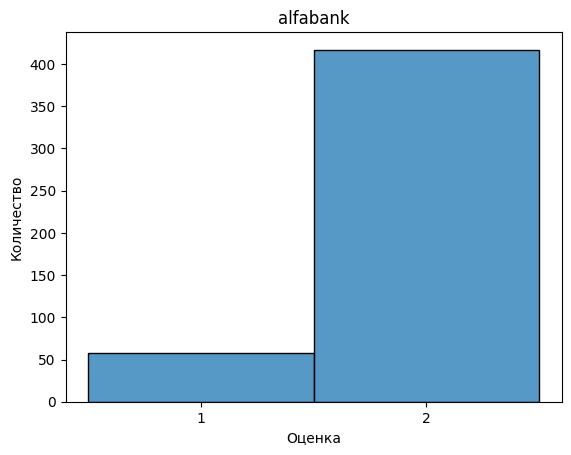

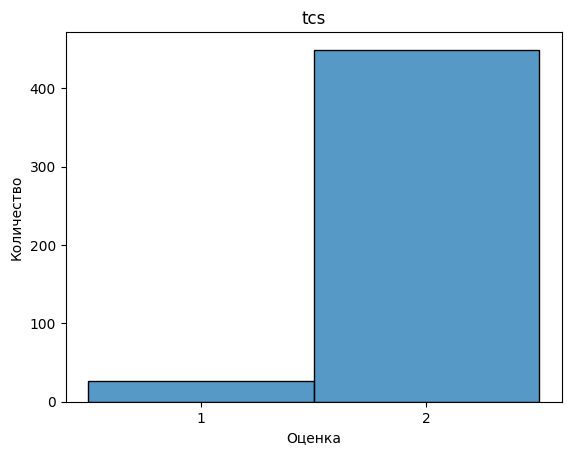

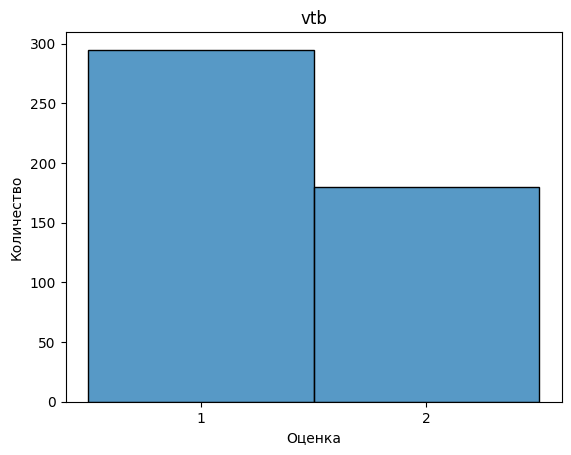

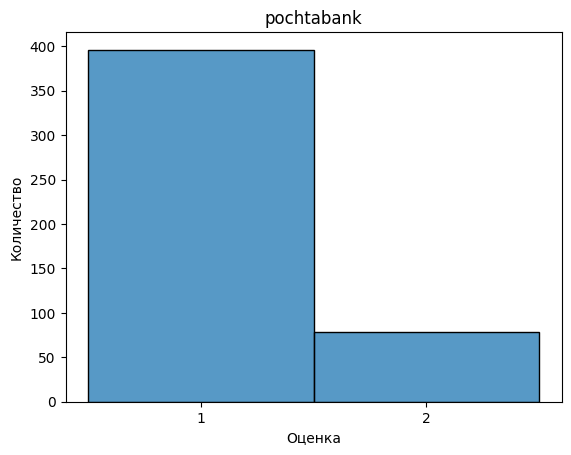

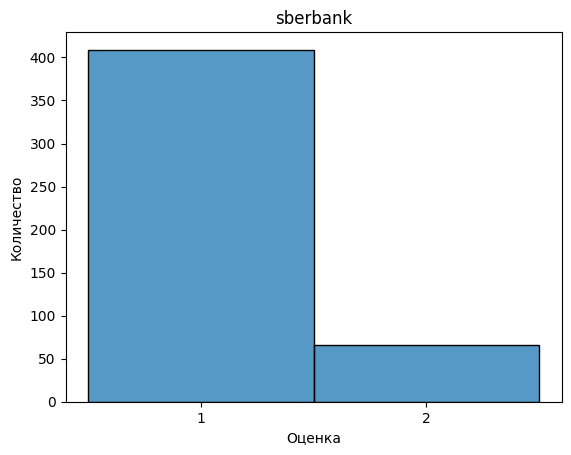

In [68]:
# посмотрим статистику по каждому банку отдельно
banks = ['alfabank', 'tcs', 'vtb', 'pochtabank', 'sberbank']
for bank in banks:
  plt.xlabel("Оценка")
  plt.ylabel("Количество")
  plt.title(bank)
  sns.histplot(data = df[df['bank']==bank], x="reviewRating", discrete=True )
  plt.xticks([1, 2])
  plt.show()

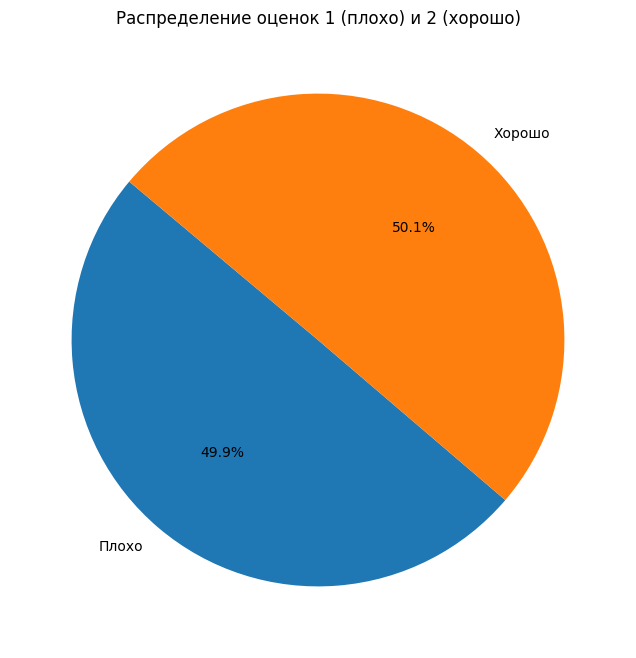

In [69]:
# Подсчитываем количество оценок 1 и 2
count_1 = len(df[df['reviewRating'] == 1])
count_2 = len(df[df['reviewRating'] == 2])

# Создаем данные для круговой диаграммы
labels = ['Плохо', 'Хорошо']
sizes = [count_1, count_2]

# Создаем круговую диаграмму
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)

plt.title('Распределение оценок 1 (плохо) и 2 (хорошо)')
plt.show()

**Вывод:** нам удалось сбалансировать классы путём объединения оценок "1", "2", "3" как "плохо" и "4", "5" как "хорошо".

Таким образом, мы избежали смещение модели в сторону преобладающего класса.

# **Построение простых моделей**

In [70]:
# Разделим данные на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, df['reviewRating'], test_size=0.2, random_state=42)

In [71]:
lr = LogisticRegression()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
svc = svm.SVC()

In [72]:
# Создаём k-блочное разбиение (KFold)

kf = KFold(n_splits = 3, shuffle=True, random_state=15)
kf

KFold(n_splits=3, random_state=15, shuffle=True)

In [73]:
not_nan_indices = ~np.isnan(y)
X = X[not_nan_indices]
y = y[not_nan_indices]

In [74]:
# Сделаем разбиение на блоки

for i, (train_index, test_index) in enumerate(kf.split(df)):
    if len(train_index) >= X.shape[0] or len(test_index) >= X.shape[0]:
        continue

    print(f"Fold {i+1}: Длинна train: {len(train_index)}, Длинна test: {len(test_index)}")
    print(f'Train: index={train_index}\n Test:  index={test_index}\n')

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


Fold 1: Длинна train: 1583, Длинна test: 792
Train: index=[   1    4    5 ... 2372 2373 2374]
 Test:  index=[   0    2    3    8   10   14   17   23   25   28   31   36   38   42
   43   44   45   46   47   51   54   56   58   60   62   64   69   80
   85   87   89   90   94  100  103  106  109  117  119  120  125  126
  128  135  136  137  139  146  147  148  150  152  157  159  160  162
  164  165  170  173  179  181  184  185  200  205  208  209  211  217
  222  223  224  225  227  228  230  233  238  239  241  242  243  244
  251  252  255  256  257  270  272  274  276  283  289  290  292  295
  298  302  303  305  306  309  310  312  313  314  316  318  320  325
  328  332  336  341  343  346  350  354  355  359  361  363  374  378
  379  380  383  384  389  392  396  397  399  400  401  405  406  409
  411  412  414  415  420  423  424  425  427  428  429  430  431  435
  438  440  441  442  443  446  449  451  453  456  465  471  472  481
  484  488  489  490  498  500  503  505

In [ ]:
for model in [lr, rfc, gbc, svc]:
    model_name = model
    cv_results = cross_val_score(model,
                                 X,  # модель
                                 y,  # матрица признаков
                                 cv=kf,  # тип разбиения
                                 scoring = 'accuracy',  # метрика
                                 n_jobs=-1)  # используются все ядра CPU
    print(f'{model_name}:')
    print(f'Кросс-валидация: , {cv_results}')
    print(f'Среднее по кросс-валидации: , {cv_results.mean()}')
    print(f'Дисперсия по кросс-валидации: , {cv_results.std()}\n')

LogisticRegression():
Кросс-валидация: , [0.83438685 0.82151899 0.83037975]
Среднее по кросс-валидации: , 0.8287618620877275
Дисперсия по кросс-валидации: , 0.005376408284433728

RandomForestClassifier():
Кросс-валидация: , [0.81415929 0.80632911 0.82658228]
Среднее по кросс-валидации: , 0.8156902281468206
Дисперсия по кросс-валидации: , 0.00833888452475462

GradientBoostingClassifier():
Кросс-валидация: , [0.80151707 0.79113924 0.80886076]
Среднее по кросс-валидации: , 0.8005056890012642
Дисперсия по кросс-валидации: , 0.0072700400229378575

SVC():
Кросс-валидация: , [0.83312263 0.81898734 0.83164557]
Среднее по кросс-валидации: , 0.8279185136584039
Дисперсия по кросс-валидации: , 0.00634401555166114



In [77]:
import time

# Создаём списки для хранения результатов
model_names = []
train_times = []
test_times = []
run_times = []
accuracies = []

for model in [lr, rfc, gbc, svc]:
    model_name = str(model).split('(')[0]
    train_time_list = []
    test_time_list = []
    accuracy_list = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        start_time = time.time()  # Засекаем начальное время тренировки
        model.fit(X_train, y_train)  # Обучаем модель
        end_time = time.time()  # Засекаем конечное время тренировки
        elapsed_train_time = end_time - start_time  # Вычисляем время тренировки

        start_time = time.time()  # Засекаем начальное время тестирования модели
        y_pred = model.predict(X_test)  # Предсказываем значения на тестовых данных
        end_time = time.time()  # Засекаем конечное время тестирования модели
        elapsed_test_time = end_time - start_time  # Вычисляем время тестирования

        accuracy = np.mean(y_pred == y_test)  # Вычисляем точность модели

        train_time_list.append(elapsed_train_time)
        test_time_list.append(elapsed_test_time)
        accuracy_list.append(accuracy)

    model_names.append(model_name)
    train_times.append(np.mean(train_time_list))
    test_times.append(np.mean(test_time_list))
    run_times.append(np.mean(train_time_list) + np.mean(test_time_list))
    accuracies.append(np.mean(accuracy_list))

results_df = pd.DataFrame({
    'Model': model_names,
    'Training time': train_times,
    'Test time': test_times,
    'Run time': run_times,
    'Accuracy': accuracies
})

results_df

,Model,Training time,Test time,Run time,Accuracy
0,LogisticRegression,0.370908,0.000554,0.371461,0.921262
1,RandomForestClassifier,1.535345,0.043610,1.578955,0.906949
2,GradientBoostingClassifier,6.341522,0.005493,6.347016,0.893048
3,SVC,1.685866,0.863341,2.549206,0.927157


**Исходя из результатов кросс-валидации, можно сделать следующие выводы:**

**LogisticRegression:**
Время обучения (Training time) низкое, всего 0.37 секунды.
Время тестирования (Test time) крайне мало и практически не влияет на общее время выполнения.
Общее время выполнения (Run time) составляет всего 0.37 секунды.
Модель достаточно точная с точностью (Accuracy) около 92.13%.

**RandomForestClassifier:**
Время обучения (Training time) выше, чем у LogisticRegression, составляет около 1.54 секунды.
Время тестирования (Test time) также небольшое, но заметно больше, чем у LogisticRegression.
Общее время выполнения (Run time) для RandomForestClassifier значительно выше, около 1.58 секунды.
Точность (Accuracy) модели все равно высокая, около 90.69%, но ниже, чем у LogisticRegression.

**GradientBoostingClassifier:**
Время обучения (Training time) заметно выше, чем у предыдущих моделей, составляет около 6.34 секунд.
Время тестирования (Test time) минимально и почти не влияет на общее время выполнения.
Общее время выполнения (Run time) для GradientBoostingClassifier составляет около 6.35 секунд.
Точность (Accuracy) модели высокая, около 89.30%, что все равно является хорошим результатом.

**SVC (Support Vector Classifier):**
Время обучения (Training time) умеренное, составляет около 1.69 секунды.
Время тестирования (Test time) наибольшее среди всех моделей и составляет около 0.86 секунды.
Общее время выполнения (Run time) для SVC достаточно высоко и составляет около 2.55 секунд.
Модель обладает высокой точностью (Accuracy) около 92.72%.

Исходя из этих результатов, выбор модели зависит от приоритетов. Если важно минимизировать время выполнения, то **LogisticRegression** является самой быстрой и все равно довольно точной моделью. Однако, если точность на первом месте и мы можем позволить некоторое увеличение времени выполнения, **SVC** предлагает высокую точность. **RandomForestClassifier** и **GradientBoostingClassifier** находятся где-то посередине в терминах точности и времени выполнения.

# **Улучшение модели SVC, используя GridSearchCV**

In [79]:
# Задаем сетку параметров для SVC
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.1, 1, 'scale', 'auto'],
    'degree': [2, 3, 4]
}

# Создаем экземпляр SVC
svc = SVC()

# Создаем объект GridSearchCV
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='accuracy', cv=kf, n_jobs=-1)

# Обучаем GridSearchCV на данных
grid_search.fit(X, y)

# Выводим наилучшие параметры и точность
print("Наилучшие параметры:", grid_search.best_params_)
print("Наилучшая точность:", grid_search.best_score_)

Наилучшие параметры: {'C': 1, 'degree': 2, 'gamma': 1, 'kernel': 'rbf'}
Наилучшая точность: 0.9271566273778663


In [86]:
# Используем лучшие параметры, найденные с помощью GridSearchCV
best_params = grid_search.best_params_
best_svc = SVC(**best_params)

# Разделяем данные на обучающий и тестовый наборы (с использованием кросс-валидации)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Обучаем модель
    best_svc.fit(X_train, y_train)

# Получаем предсказания
y_pred = best_svc.predict(X_test)

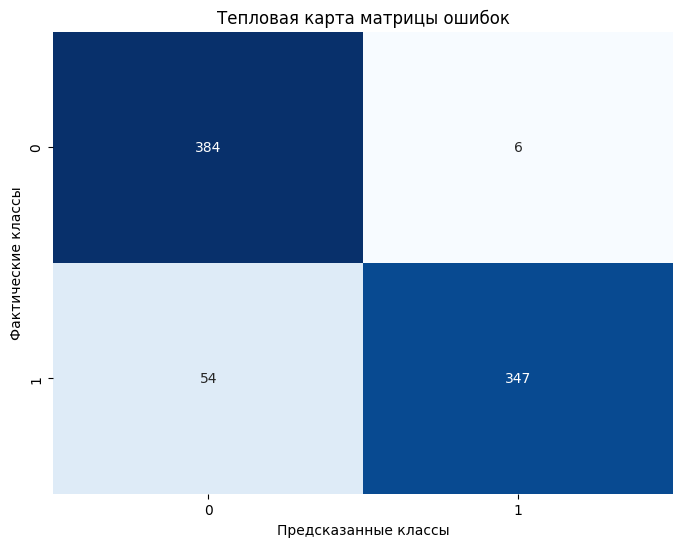

Отчёт классификации:
               precision    recall  f1-score   support

           1       0.88      0.98      0.93       390
           2       0.98      0.87      0.92       401

    accuracy                           0.92       791
   macro avg       0.93      0.92      0.92       791
weighted avg       0.93      0.92      0.92       791



In [87]:
# Постройте матрицу ошибок
confusion = confusion_matrix(y_test, y_pred)

# Строим тепловую карту на основе матрицы ошибок
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Предсказанные классы")
plt.ylabel("Фактические классы")
plt.title("Тепловая карта матрицы ошибок")
plt.show()

# Выводим отчёт классификации
classification_rep = classification_report(y_test, y_pred)
print("Отчёт классификации:\n", classification_rep)


**Вывод:** по тепловой карте видим, что модель достаточно хорошо предсказывает классы, однако всё-равно 54 ошибочных предсказания класса является не лучшим результатом, попробуем протестировать модель на введённых пользователем отзвах.

# **Тестирование модели SVC**

In [98]:
# Функция для предобработки текста
def preprocess_text(text):
    # Приведем текст к нижнему регистру
    text = text.lower()

    # Инициализируем объект для лемматизации
    morph = pymorphy2.MorphAnalyzer()

    # Загрузим список стоп-слов для русского языка
    stopWords = set(stopwords.words('russian'))

    # Токенизация и лемматизация
    tokens = text.split()
    tokens = [morph.parse(token)[0].normalized.word for token in tokens if token not in stopWords and not re.search('[^а-яА-Я0-9]', token)]

    return ' '.join(tokens)

# Функция для предсказания оценки отзыва
def predict_review_rating(user_input, model, tfidf_vectorizer):
    # Предобработка текста
    user_input = preprocess_text(user_input)

    # Преобразование вектора TF-IDF
    user_input_vector = tfidf_vectorizer.transform([user_input])

    # Предсказание оценки
    predicted_rating = model.predict(user_input_vector)

    if predicted_rating == 2:
        return "Модель считает, что отзыв ХОРОШИЙ"
    else:
        return "Модель считает, что отзыв ПЛОХОЙ"

In [99]:
user_input = input("Введите текст отзыва: ")

# Ваш код для вызова функции predict_review_rating
result = predict_review_rating(user_input, best_svc, tfidf)

print(result)

Введите текст отзыва: Прекрасные консультанты, которые готовы помочь в любом вопросе. Рада, что пользуюсь именно этим банком.
Модель считает, что отзыв ХОРОШИЙ


In [100]:
user_input = input("Введите текст отзыва: ")

# Ваш код для вызова функции predict_review_rating
result = predict_review_rating(user_input, best_svc, tfidf)

print(result)

Введите текст отзыва: Возникла проблема с кредитной картой, не смогла дозвониться по горячей линии, долгое ожидание
Модель считает, что отзыв ПЛОХОЙ


In [102]:
user_input = input("Введите текст отзыва: ")

# Ваш код для вызова функции predict_review_rating
result = predict_review_rating(user_input, best_svc, tfidf)

print(result)

Введите текст отзыва: Радует этот банк за большие кешбэки и бесплатное обслуживание карты 
Модель считает, что отзыв ХОРОШИЙ


In [103]:
user_input = input("Введите текст отзыва: ")

# Ваш код для вызова функции predict_review_rating
result = predict_review_rating(user_input, best_svc, tfidf)

print(result)

Введите текст отзыва: Обращалась в этот банк за помощью в открытии накопительного счёта, объяснили все нюансы и помогли подобрать наилучший вариант
Модель считает, что отзыв ХОРОШИЙ


In [104]:
user_input = input("Введите текст отзыва: ")

# Ваш код для вызова функции predict_review_rating
result = predict_review_rating(user_input, best_svc, tfidf)

print(result)

Введите текст отзыва: плохо
Модель считает, что отзыв ПЛОХОЙ


In [105]:
user_input = input("Введите текст отзыва: ")

# Ваш код для вызова функции predict_review_rating
result = predict_review_rating(user_input, best_svc, tfidf)

print(result)

Введите текст отзыва: хорошо
Модель считает, что отзыв ХОРОШИЙ


**Вывод:** в тестировании модель показала хорошие результаты, все введённые мной отзывы классифицировала верно.

# **Выводы по всей работе:**

В ходе данной работы был проведен анализ данных отзывов, написанных о банках. Набор данных включал в себя текстовые описания отзывов, заголовки отзывов и их оценки, выраженные в виде чисел 1, 2, 3, 4, 5.

Первоначальный анализ данных показал, что в данных присутствует дисбаланс классов оценок, где количество отзывов с оценками 1 и 5 преобладает над оценками 2, 3, 4. Для решения этой проблемы были предприняты шаги по уравниванию баланса классов, а именно объединение оценок 1, 2, 3 в один класс "плохой" (1), и объединение оценок 4, 5 в "хороший" (2).

Затем данные были подготовлены для обучения моделей. Текстовые описания отзывов были преобразованы в числовые признаки с использованием метода TF-IDF. Для обучения и оценки моделей были выбраны следующие классификаторы: Logistic Regression, Random Forest Classifier, Gradient Boosting Classifier и Support Vector Classifier (SVC).

Модели были обучены с использованием кросс-валидации на нескольких разбиениях данных. По результатам кросс-валидации модель SVC показала наилучшую точность предсказания оценок отзывов. Далее, был выполнен поиск наилучших параметров для модели SVC с использованием GridSearchCV.

После нахождения наилучших параметров, модель SVC была обучена на всем наборе данных и оценена на тестовых данных, предоставленных пользователем. В конечном итоге, модель предсказала оценку (1 - "плохо" или 2 - "хорошо") для введенного пользователем текста отзыва.

Таким образом, в результате данной работы была разработана модель для анализа текстовых отзывов о банках и предсказания их оценок. Модель была обучена на сбалансированных данных, подобраны наилучшие параметры и успешно протестирована на данных пользователя.